In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.606065,0.916197,00:03
1,0.855258,0.671490,00:03
2,0.654001,0.664738,00:03


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [9]:
path = Path('/root/fastai/course-v3/nbs/dl1/data/ml-100k/')
# ! unzip path (from terminal)

In [10]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
len(ratings)

100000

In [13]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [14]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [15]:
data.show_batch()

userId,title,target
556,Vertigo (1958),5.0
102,Made in America (1993),2.0
727,Indiana Jones and the Last Crusade (1989),3.0
733,Once Upon a Time... When We Were Colored (1995),2.0
561,Cold Comfort Farm (1995),4.0


In [16]:
y_range = [0,5.5]

In [17]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


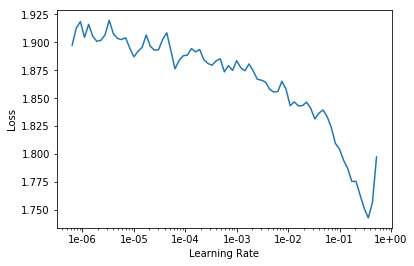

In [19]:
learn.recorder.plot(skip_end=15)

In [20]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.956679,0.945737,00:12
1,0.897694,0.885138,00:12
2,0.785086,0.832049,00:12
3,0.647706,0.813449,00:12
4,0.568230,0.811926,00:13


In [21]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [22]:
learn.load('dotprod');

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [39]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [40]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [42]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [43]:
item0 = lambda o:o[0]

In [44]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3714),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3165), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3124),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2916), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2811), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2523), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2422), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2380), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2313), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2305), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2289), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2238), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2229), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2144), 'Thinner (1996)', 2.4489795918367347),
 (tensor

In [45]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5961), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5642), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5556), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5448), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5433), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5386), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5230), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4941), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4898), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4841), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4776), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4665), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4638), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4571), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4526), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667)]

### Movie weights

In [46]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [47]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [48]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1646), 'Wrong Trousers, The (1993)'),
 (tensor(1.1569), 'Close Shave, A (1995)'),
 (tensor(1.0934), 'Casablanca (1942)'),
 (tensor(1.0734), 'Chinatown (1974)'),
 (tensor(1.0326),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9814), 'Third Man, The (1949)'),
 (tensor(0.9758), 'When We Were Kings (1996)'),
 (tensor(0.9578), 'Manchurian Candidate, The (1962)'),
 (tensor(0.9577), 'Godfather, The (1972)'),
 (tensor(0.9577), 'Lawrence of Arabia (1962)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2647), 'Jungle2Jungle (1997)'),
 (tensor(-1.2549), "McHale's Navy (1997)"),
 (tensor(-1.2314), 'Leave It to Beaver (1997)'),
 (tensor(-1.2229), 'Home Alone 3 (1997)'),
 (tensor(-1.2070), 'Congo (1995)'),
 (tensor(-1.1820), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0874), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0642), 'Bio-Dome (1996)'),
 (tensor(-1.0289), 'Flipper (1996)'),
 (tensor(-1.0245), 'Grease 2 (1982)')]

In [35]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [36]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0052), 'Keys to Tulsa (1997)'),
 (tensor(0.8273), 'Trainspotting (1996)'),
 (tensor(0.8255), 'Jude (1996)'),
 (tensor(0.7918), 'Cable Guy, The (1996)'),
 (tensor(0.7760), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7753), 'Clockwork Orange, A (1971)'),
 (tensor(0.7390), 'Brazil (1985)'),
 (tensor(0.7325), 'Lost Highway (1997)'),
 (tensor(0.7292), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7261), 'Very Brady Sequel, A (1996)')]

In [37]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1948), 'Braveheart (1995)'),
 (tensor(-1.0547), 'Titanic (1997)'),
 (tensor(-1.0358), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9223), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8886), 'American President, The (1995)'),
 (tensor(-0.8648), 'Forrest Gump (1994)'),
 (tensor(-0.8500), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8495), 'Top Gun (1986)'),
 (tensor(-0.8362), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8339), "It's a Wonderful Life (1946)")]

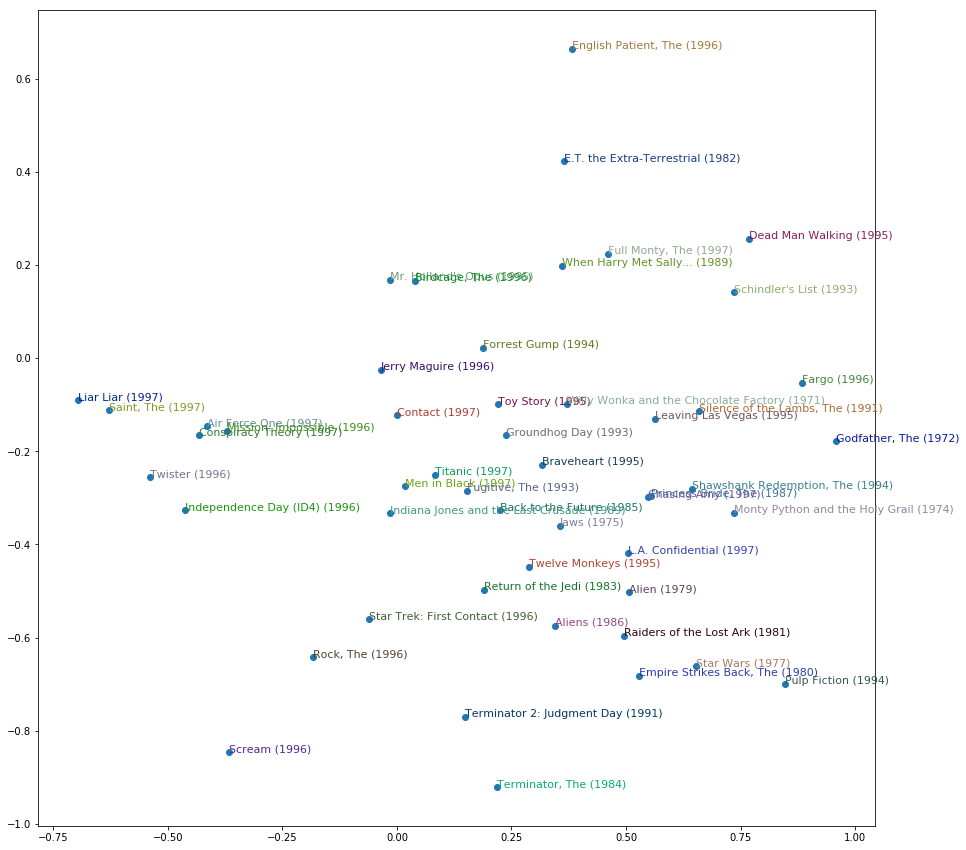

In [53]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()